In [18]:
import pandas as pd
import warnings

from scipy import stats
from itertools import combinations
from sklearn import preprocessing

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [20]:
warnings.simplefilter('ignore')

In [21]:
def mirror_d1d2_iter(df):
    for r1 in df.to_dict('records'):
        yield r1
        r2 = r1.copy()
        r2['d1'], r2['d2'] = r2['d2'], r2['d1']
        yield r2

In [22]:
def mirror_d1d2(df):
    return pd.DataFrame(list(mirror_d1d2_iter(df)))

# All-vs-all probability mass correlations - LSTM

In [23]:
lstm_pcorr = pd.read_json('data/hl-graph-lstm-pcorr.json', lines=True)
lstm_pcorr = mirror_d1d2(lstm_pcorr)
lstm_pcorr = lstm_pcorr.drop(columns=['kt_p', 'pr_p', 'sp_p'])
lstm_pcorr = lstm_pcorr.set_index(['d1', 'd2'])
lstm_pcorr = lstm_pcorr.add_prefix('lstm_pcorr_')
lstm_pcorr = lstm_pcorr.reset_index()

In [24]:
lstm_pcorr.sort_values('lstm_pcorr_kt', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp
52,bloomberg.com,wsj.com,0.544591,0.244900,0.730285
53,wsj.com,bloomberg.com,0.544591,0.244900,0.730285
59,dailycaller.com,breitbart.com,0.504639,0.235545,0.688357
58,breitbart.com,dailycaller.com,0.504639,0.235545,0.688357
203,wsj.com,nytimes.com,0.489553,0.158381,0.672381
202,nytimes.com,wsj.com,0.489553,0.158381,0.672381
184,msnbc.com,thehill.com,0.478135,0.121547,0.660237
185,thehill.com,msnbc.com,0.478135,0.121547,0.660237
190,npr.org,nytimes.com,0.468058,0.189297,0.645672
191,nytimes.com,npr.org,0.468058,0.189297,0.645672


# All-vs-all probability mass correlations - LR

In [25]:
lr_pcorr = pd.read_json('data/hl-graph-lr-pcorr.json', lines=True)
lr_pcorr = mirror_d1d2(lr_pcorr)
lr_pcorr = lr_pcorr.rename(columns={'kt_corr': 'kt', 'pr_corr': 'pr', 'sp_corr': 'sp'})
lr_pcorr = lr_pcorr.set_index(['d1', 'd2'])
lr_pcorr = lr_pcorr.add_prefix('lr_pcorr_')
lr_pcorr = lr_pcorr.reset_index()

In [26]:
lr_pcorr.sort_values('lr_pcorr_kt', ascending=False).head(10)

,d1,d2,lr_pcorr_kt,lr_pcorr_pr,lr_pcorr_sp
53,wsj.com,bloomberg.com,0.558039,0.413881,0.744076
52,bloomberg.com,wsj.com,0.558039,0.413881,0.744076
12,apnews.com,foxnews.com,0.496469,0.353088,0.681913
13,foxnews.com,apnews.com,0.496469,0.353088,0.681913
190,npr.org,nytimes.com,0.480019,0.313131,0.657344
191,nytimes.com,npr.org,0.480019,0.313131,0.657344
184,msnbc.com,thehill.com,0.433828,0.233331,0.601685
185,thehill.com,msnbc.com,0.433828,0.233331,0.601685
87,huffingtonpost.com,buzzfeed.com,0.427143,0.130748,0.584316
86,buzzfeed.com,huffingtonpost.com,0.427143,0.130748,0.584316


# All-vs-all confusion counts - LSTM

In [40]:
lstm_cm = pd.read_json('data/hl-graph-lstm-cm.json', lines=True)
lstm_cm = lstm_cm.set_index(['d1', 'd2'])
lstm_cm = lstm_cm.add_prefix('lstm_cm_')
lstm_cm = lstm_cm.reset_index()

In [41]:
lstm_cm.sort_values('lstm_cm_count', ascending=False).head(10)

,d1,d2,lstm_cm_count
197,wsj.com,bloomberg.com,362
72,dailycaller.com,breitbart.com,321
98,foxnews.com,apnews.com,275
27,bloomberg.com,wsj.com,267
177,thehill.com,msnbc.com,267
81,dailycaller.com,thehill.com,253
137,msnbc.com,thehill.com,232
64,cnn.com,msnbc.com,232
150,npr.org,nytimes.com,215
67,cnn.com,thehill.com,210


# A-vs-B accuracies - LR + SVC

In [29]:
ab_acc = pd.read_json('data/hl-graph-ab-acc.json', lines=True)
ab_acc = mirror_d1d2(ab_acc)

# Use 1-acc, so that high score -> high similarity.
ab_acc['inv_lr'] = 1 - ab_acc.acc_lr
ab_acc['inv_svc'] = 1 - ab_acc.acc_svc
ab_acc = ab_acc.drop(columns=['acc_lr', 'acc_svc'])

ab_acc = ab_acc.set_index(['d1', 'd2'])
ab_acc = ab_acc.add_prefix('ab_acc_')
ab_acc = ab_acc.reset_index()

In [30]:
ab_acc.sort_values('ab_acc_inv_lr', ascending=False).head(10)

,d1,d2,ab_acc_inv_lr,ab_acc_inv_svc
157,npr.org,nytimes.com,0.338326,0.332244
156,nytimes.com,npr.org,0.338326,0.332244
50,cnn.com,foxnews.com,0.324286,0.314910
51,foxnews.com,cnn.com,0.324286,0.314910
184,washingtonpost.com,npr.org,0.322073,0.314567
185,npr.org,washingtonpost.com,0.322073,0.314567
161,washingtonpost.com,nytimes.com,0.315189,0.314865
160,nytimes.com,washingtonpost.com,0.315189,0.314865
22,bloomberg.com,wsj.com,0.314593,0.309884
23,wsj.com,bloomberg.com,0.314593,0.309884


# A-vs-B confusion counts - LR

In [31]:
ab_cm_lr = pd.read_json('data/hl-graph-ab-cm-lr.json', lines=True)
ab_cm_lr = ab_cm_lr.rename(columns={'count': 'ab_cm_lr_count'})

In [32]:
ab_cm_lr.sort_values('ab_cm_lr_count', ascending=False).head(10)

,ab_cm_lr_count,d1,d2
68,2133.74,cnn.com,washingtonpost.com
166,2052.58,nytimes.com,washingtonpost.com
152,1934.01,npr.org,washingtonpost.com
124,1894.24,huffingtonpost.com,washingtonpost.com
63,1833.32,cnn.com,huffingtonpost.com
60,1822.31,cnn.com,dailycaller.com
65,1814.03,cnn.com,npr.org
62,1754.52,cnn.com,foxnews.com
61,1753.54,cnn.com,dailykos.com
197,1742.23,wsj.com,bloomberg.com


# A-vs-B confusions counts - SVC

In [33]:
ab_cm_svc = pd.read_json('data/hl-graph-ab-cm-svc.json', lines=True)
ab_cm_svc = ab_cm_svc.rename(columns={'count': 'ab_cm_svc_count'})

In [34]:
ab_cm_svc.sort_values('ab_cm_svc_count', ascending=False).head(10)

,ab_cm_svc_count,d1,d2
68,2187.51,cnn.com,washingtonpost.com
166,2181.79,nytimes.com,washingtonpost.com
152,1973.93,npr.org,washingtonpost.com
63,1835.90,cnn.com,huffingtonpost.com
124,1808.89,huffingtonpost.com,washingtonpost.com
62,1791.70,cnn.com,foxnews.com
60,1780.71,cnn.com,dailycaller.com
197,1772.99,wsj.com,bloomberg.com
65,1761.37,cnn.com,npr.org
164,1752.33,nytimes.com,npr.org


# All-vs-all confusion counts - LR

In [35]:
ava_cm_lr = pd.read_json('data/hl-graph-ava-cm-lr.json', lines=True)
ava_cm_lr = ava_cm_lr.rename(columns={'count': 'ava_cm_lr_count'})

In [36]:
ava_cm_lr.sort_values('ava_cm_lr_count', ascending=False).head(10)

,ava_cm_lr_count,d1,d2
197,999.633,wsj.com,bloomberg.com
115,894.667,huffingtonpost.com,buzzfeed.com
177,653.345,thehill.com,msnbc.com
188,600.023,washingtonpost.com,dailykos.com
98,590.786,foxnews.com,apnews.com
132,561.900,msnbc.com,dailykos.com
185,544.365,washingtonpost.com,buzzfeed.com
64,535.291,cnn.com,msnbc.com
118,516.878,huffingtonpost.com,dailykos.com
137,496.345,msnbc.com,thehill.com


# All-vs-all confusion counts - SVC

In [37]:
ava_cm_svc = pd.read_json('data/hl-graph-ava-cm-svc.json', lines=True)
ava_cm_svc = ava_cm_svc.rename(columns={'count': 'ava_cm_svc_count'})

In [38]:
ava_cm_svc.sort_values('ava_cm_svc_count', ascending=False).head(10)

,ava_cm_svc_count,d1,d2
197,958.204,wsj.com,bloomberg.com
115,838.648,huffingtonpost.com,buzzfeed.com
188,552.011,washingtonpost.com,dailykos.com
132,543.985,msnbc.com,dailykos.com
177,523.013,thehill.com,msnbc.com
72,517.675,dailycaller.com,breitbart.com
27,514.217,bloomberg.com,wsj.com
118,509.411,huffingtonpost.com,dailykos.com
6,499.532,apnews.com,foxnews.com
185,495.317,washingtonpost.com,buzzfeed.com


# All metrics

In [64]:
df = lstm_pcorr.merge(lr_pcorr).merge(lstm_cm).merge(ab_acc).merge(ab_cm_lr).merge(ab_cm_svc).merge(ava_cm_lr).merge(ava_cm_svc)

In [65]:
df.sort_values('lstm_cm_count', ascending=False).head(10)

,d1,d2,lstm_pcorr_kt,lstm_pcorr_pr,lstm_pcorr_sp,lr_pcorr_kt,lr_pcorr_pr,lr_pcorr_sp,lstm_cm_count,ab_acc_inv_lr,ab_acc_inv_svc,ab_cm_lr_count,ab_cm_svc_count,ava_cm_lr_count,ava_cm_svc_count
53,wsj.com,bloomberg.com,0.544591,0.244900,0.730285,0.558039,0.413881,0.744076,362,0.314593,0.309884,1742.23,1772.99,999.633,958.204
59,dailycaller.com,breitbart.com,0.504639,0.235545,0.688357,0.370343,0.210245,0.522243,321,0.302224,0.295565,1281.06,1270.25,475.826,517.675
13,foxnews.com,apnews.com,0.240590,0.096741,0.343792,0.496469,0.353088,0.681913,275,0.299040,0.293665,1176.14,1040.06,590.786,469.860
185,thehill.com,msnbc.com,0.478135,0.121547,0.660237,0.433828,0.233331,0.601685,267,0.273898,0.264022,1342.74,1230.49,653.345,523.013
52,bloomberg.com,wsj.com,0.544591,0.244900,0.730285,0.558039,0.413881,0.744076,267,0.314593,0.309884,1219.65,1134.00,474.416,514.217
132,dailycaller.com,thehill.com,0.426649,0.138389,0.597465,0.337392,0.148710,0.479668,253,0.279767,0.268648,1303.21,1232.58,461.953,412.967
184,msnbc.com,thehill.com,0.478135,0.121547,0.660237,0.433828,0.233331,0.601685,232,0.273898,0.264022,1241.64,1247.44,496.345,475.824
108,cnn.com,msnbc.com,0.409234,0.152077,0.573168,0.212435,0.049913,0.307652,232,0.255859,0.247469,1506.88,1494.11,535.291,427.206
190,npr.org,nytimes.com,0.468058,0.189297,0.645672,0.480019,0.313131,0.657344,215,0.338326,0.332244,1475.18,1376.91,444.095,352.941
114,cnn.com,thehill.com,0.266552,0.052812,0.386499,0.179786,0.021425,0.263981,210,0.276821,0.271013,1661.21,1692.81,425.506,390.519


Group on `d1`, scale scores with other outlets.

In [66]:
for col in set(df.columns) - {'d1', 'd2'}:
    df[f'{col}_scaled'] = df.groupby('d1')[col].transform(preprocessing.scale)

In [67]:
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [68]:
df_melted = df.melt(['d1', 'd2', 'label'], [c for c in df.columns if c.endswith('_scaled')])

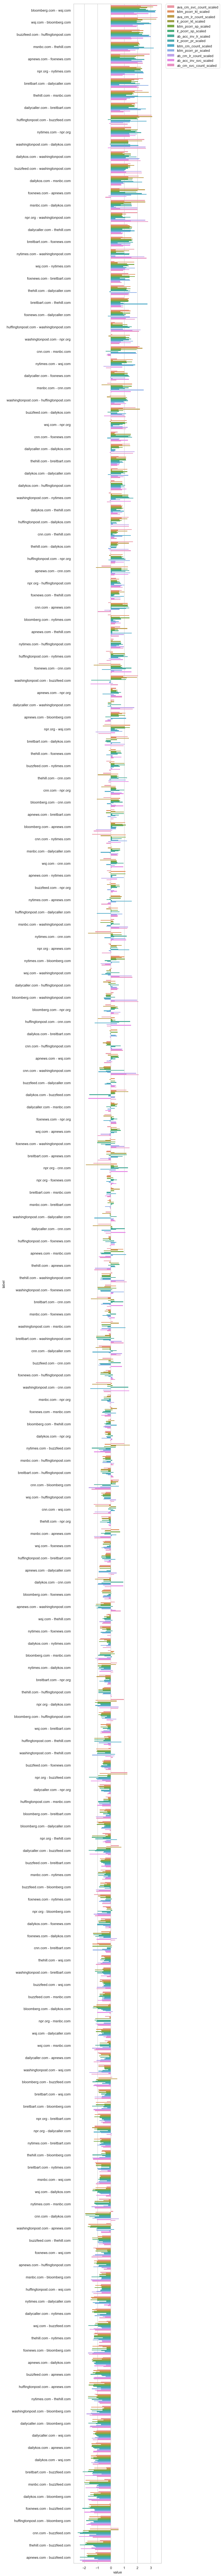

In [69]:
df_melted = df.melt(['d1', 'd2', 'label'], [c for c in df.columns if c.endswith('_scaled')])

# Sort by mean score.
order = df_melted.groupby('label').mean().sort_values('value', ascending=False).index

plt.figure(figsize=(5,150))
ax = sns.barplot(x='value', y='label', data=df_melted, hue='variable', order=order, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [70]:
df.to_json('data/hl-graph.json', orient='records', lines=True)